In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
from example_package import model, training, datasets

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def VisualizeReconstruction(original, reconstructed):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Original Data")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Reconstructed Data")
    plt.axis('off')

    plt.show()

In [3]:
n_visible = 4
n_hidden = 2
dataset = datasets.BasicEncoderDataset(n_visible).data[:]

In [4]:
dataset

tensor([[1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]])

In [67]:
'''n_visible = 4
n_hidden = 2
reps = 4
dataset = datasets.CorrelatedEncoderDataset(n_visible,reps).data[:]
test_dataset = datasets.CorrelatedEncoderDataset(n_visible,1).data[:]'''

'n_visible = 4\nn_hidden = 2\nreps = 4\ndataset = datasets.CorrelatedEncoderDataset(n_visible,reps).data[:]\ntest_dataset = datasets.CorrelatedEncoderDataset(n_visible,1).data[:]'

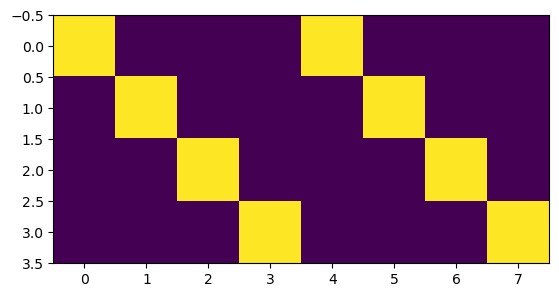

In [6]:
plt.imshow(dataset)

In [7]:
#noise_levels = [0.05,0.15]
epochs = 2000
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
train_params = {
    'double_clamped':False, #bad, do not use
    'discretize_gradients':True
}
# Make an object from the model and train it
model_B = model.BoltzmannMachine(2*n_visible, n_hidden, None, bias)
training.TrainBatch(model_B,dataset, epochs, learning_rate,noise_levels,steps_statistics,annealing_scheme,
                    train_params)

100%|██████████| 2000/2000 [01:02<00:00, 32.06it/s]


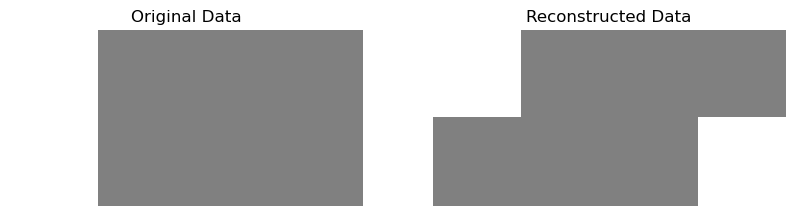

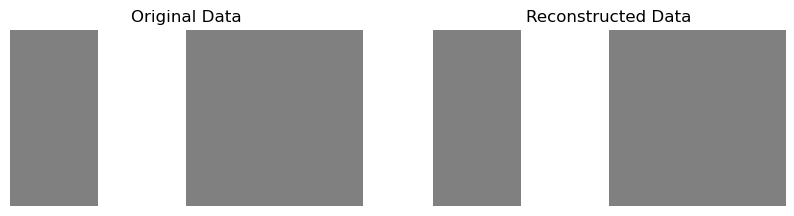

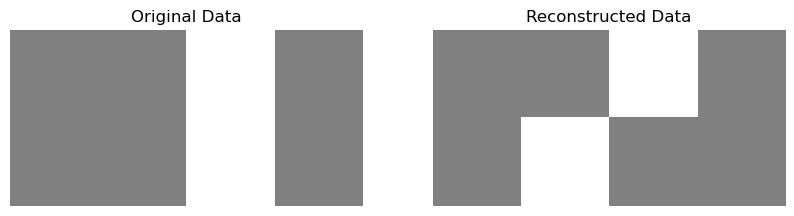

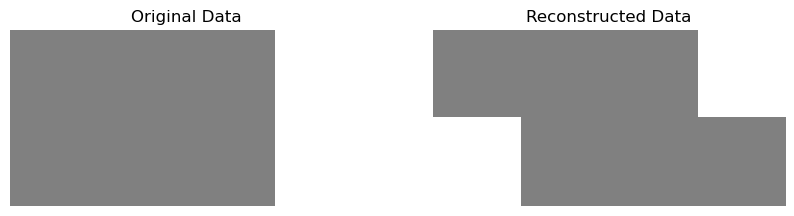

In [8]:
# Test the model for reconstruction (denoising) of the training set
reconstruction_scheme = torch.Tensor([20,20,20,20,15,15,15,15,12,12,12,12,5,5,5,5,5,5,5,5])
for i in range(dataset.size(0)):
    original_data = dataset[i]
    clamped_units = torch.cat((torch.ones(model_B.nv//2),torch.zeros(model_B.nv//2+model_B.nh)))
    reconstructed_data, _ = model_B.GoToEquilibriumState(original_data, clamped_units, reconstruction_scheme)
    
    # Visualize original vs reconstructed data
    VisualizeReconstruction(original_data.numpy(), reconstructed_data.numpy())

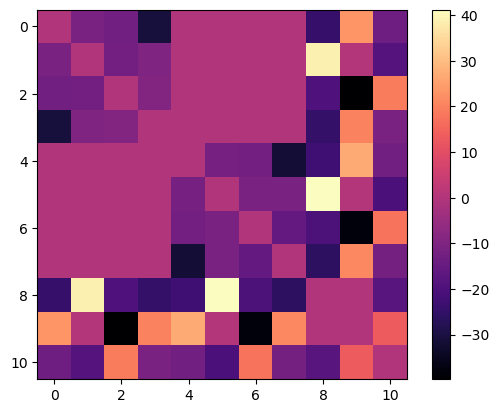

In [9]:
y=model_B.w.detach().numpy()
plt.imshow(y,cmap='magma')
plt.colorbar()

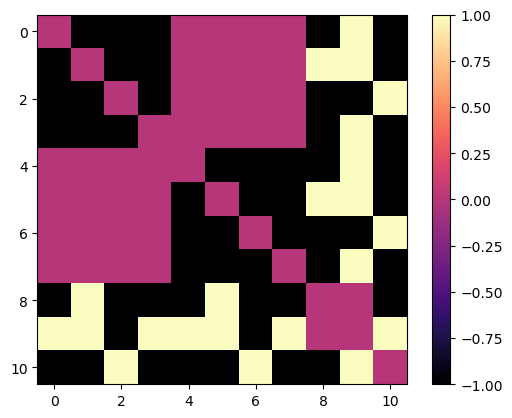

In [10]:
y_discrete = np.sign(y)
plt.imshow(y_discrete,cmap='magma')
plt.colorbar()

C:\Users\Mark\AppData\Local\Temp\ipykernel_1492\3971859139.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


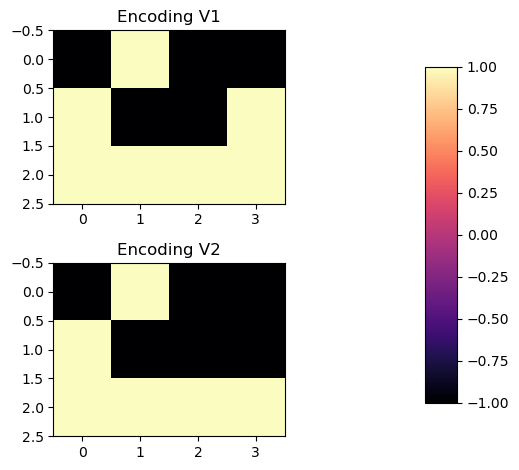

In [11]:
"""y=model_B.w.detach().numpy()
y_discrete = np.sign(y)
fig,axes = plt.subplots(2)
encoding_v1 = y_discrete[2*n_visible:,:n_visible]
encoding_v2 = y_discrete[2*n_visible:,n_visible:2*n_visible]
im = axes[0].imshow(encoding_v1,cmap='magma')
axes[1].imshow(encoding_v2,cmap='magma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
axes[0].set_title('Encoding V1')
axes[1].set_title('Encoding V2')
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()"""

/tmp/ipykernel_100249/1935657552.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


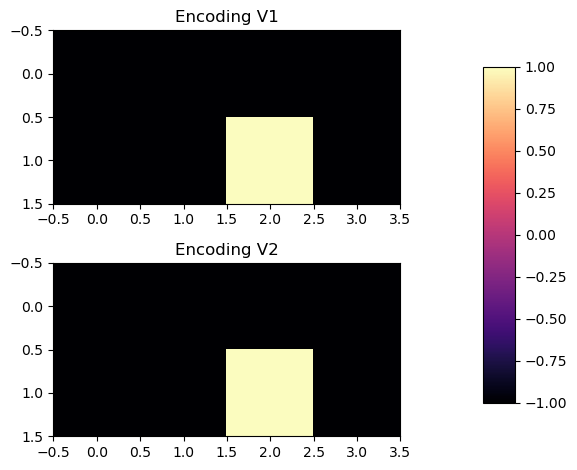

In [94]:
y = model_B.w.detach().numpy()
y_discrete = np.sign(y)

# Exclude the last row (bin row) from the encodings
encoding_v1 = y_discrete[2*n_visible:-1, :n_visible]  # Exclude the last row
encoding_v2 = y_discrete[2*n_visible:-1, n_visible:2*n_visible]  # Exclude the last row

fig, axes = plt.subplots(2)
im = axes[0].imshow(encoding_v1, cmap='magma')
axes[1].imshow(encoding_v2, cmap='magma')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
axes[0].set_title('Encoding V1')
axes[1].set_title('Encoding V2')
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

In [ ]:
import itertools

def hamming_distance(vectors):
    # Generate all unique pairs of vectors
    pairs = itertools.combinations(vectors, 2)
    distances = []
    for v1, v2 in pairs:
        # Calculate Hamming distance for the current pair
        distance = sum(1 for a, b in zip(v1, v2) if a != b)
        distances.append(distance)
    
    mean_distance = sum(distances) / len(distances)
    min_distance = min(distances)
    
    return distances, mean_distance, min_distance

result = hamming_distance(encoding_v1.T)
result

([1, 1, 0, 2, 1, 1], 1.0, 0)

In [ ]:
def has_similar_pairs(encodings):
    encodings = np.array(encodings)
    assert encodings.shape[0] == 2, "Input must contain exactly two encodings"
    
    encoding_0 = encodings[0]
    encoding_1 = encodings[1]
    
    pairs = list(zip(encoding_0, encoding_1))
    
    unique_pairs = set(pairs)
    if len(unique_pairs) < len(pairs):
        return True
    else:
        return False


print(has_similar_pairs(encoding_v1))

True


In [ ]:
encoding_v1

2
2


array([[-1.,  1., -1., -1.],
       [ 1.,  1., -1.,  1.]], dtype=float32)

In [61]:
min_hamming_distance(encoding_v1)

np.int64(2)

In [62]:
check_linear_independence(encoding_v1)

np.True_

In [114]:
n_visible = 4
n_hidden = 2
# Define the training set, there are n_visible possible patterns
v_active = torch.tensor([[1, 0, 0, 0, 1, 0, 0, 0],
                        [0, 1, 0, 0, 0, 1, 0, 0],
                        [0, 0, 1, 0, 0, 0, 1, 0],
                        [0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.float32)
v = -torch.ones((n_visible,2*n_visible))+2*v_active

# Create a Boltzmann Machine
b1 = example_package.BoltzmannMachine(8, 2, mode='binary')

# Train the network and plot weights at specific epochs
example_package.TrainBatch(b1,v, epochs=20, learningRate=2, plot_intervals=[5, 15],noise_levels=noise_levels,T=temperature)

NameError: name 'example_package' is not defined

In [ ]:
def PlotWeights_simple(weights, epoch):
        plt.figure(figsize=(8, 6))
        plt.imshow(weights, cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title(f'Weight Matrix at Epoch {epoch}')
        plt.xlabel('Units')
        plt.ylabel('Units')
        plt.show()

def PlotWeights(model, epoch):
    # Get the weight matrix
    weight_matrix = model.w.detach().cpu().numpy()
    
    # Define the structure of the network
    nv1 = model.nv // 2  # Number of visible units
    nv2 = model.nv // 2  # Number of visible units
    nh = model.nh        # Number of hidden units
    
    # Create a figure for the entire network
    fig, axes = plt.subplots(nv1 + nh + nv2, 1, figsize=(10, 2 * (nv1 + nh + nv2)))
    
    # Define labels for the units
    unit_labels = [f'V1_{i+1}' for i in range(nv1)] + \
                    [f'H_{i+1}' for i in range(nh)] + \
                    [f'V2_{i+1}' for i in range(nv2)]
    
    # Iterate over each unit and plot its connections
    for i in range(model.n):
        # Create a subplot for the current unit
        ax = axes[i]
        
        # Extract the weights for the current unit (1D array of size 10)
        unit_weights = weight_matrix[i, :]
        
        # Reshape the weights into a 2D grid for visualization
        unit_weights_grid = unit_weights.reshape(1, -1)  # Reshape to (1, 10)
        
        # Plot the weights as a heatmap
        im = ax.imshow(unit_weights_grid, cmap='viridis', vmin=-1, vmax=1, aspect='auto')
        
        # Add labels to the x-axis
        ax.set_xticks(range(model.n))
        ax.set_xticklabels(unit_labels, rotation=90)
        
        # Add a title to the subplot
        ax.set_title(f'Unit {i+1} ({unit_labels[i]}) Connections')
        
        # Hide y-axis ticks
        ax.set_yticks([])
        
        # Add a colorbar for each subplot
        plt.colorbar(im, ax=ax)
        
        # Add background shading to distinguish visible and hidden units
        for j in range(model.n):
            if j < nv1:
                ax.axvspan(j - 0.5, j + 0.5, color='lightblue', alpha=0.3)  # V1 units
            elif j < nv1 + nh:
                ax.axvspan(j - 0.5, j + 0.5, color='lightgreen', alpha=0.3)  # Hidden units
            else:
                ax.axvspan(j - 0.5, j + 0.5, color='lightcoral', alpha=0.3)  # V2 units
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.suptitle(f'Weight Visualization at Epoch {epoch}', y=1.02)
    plt.show()

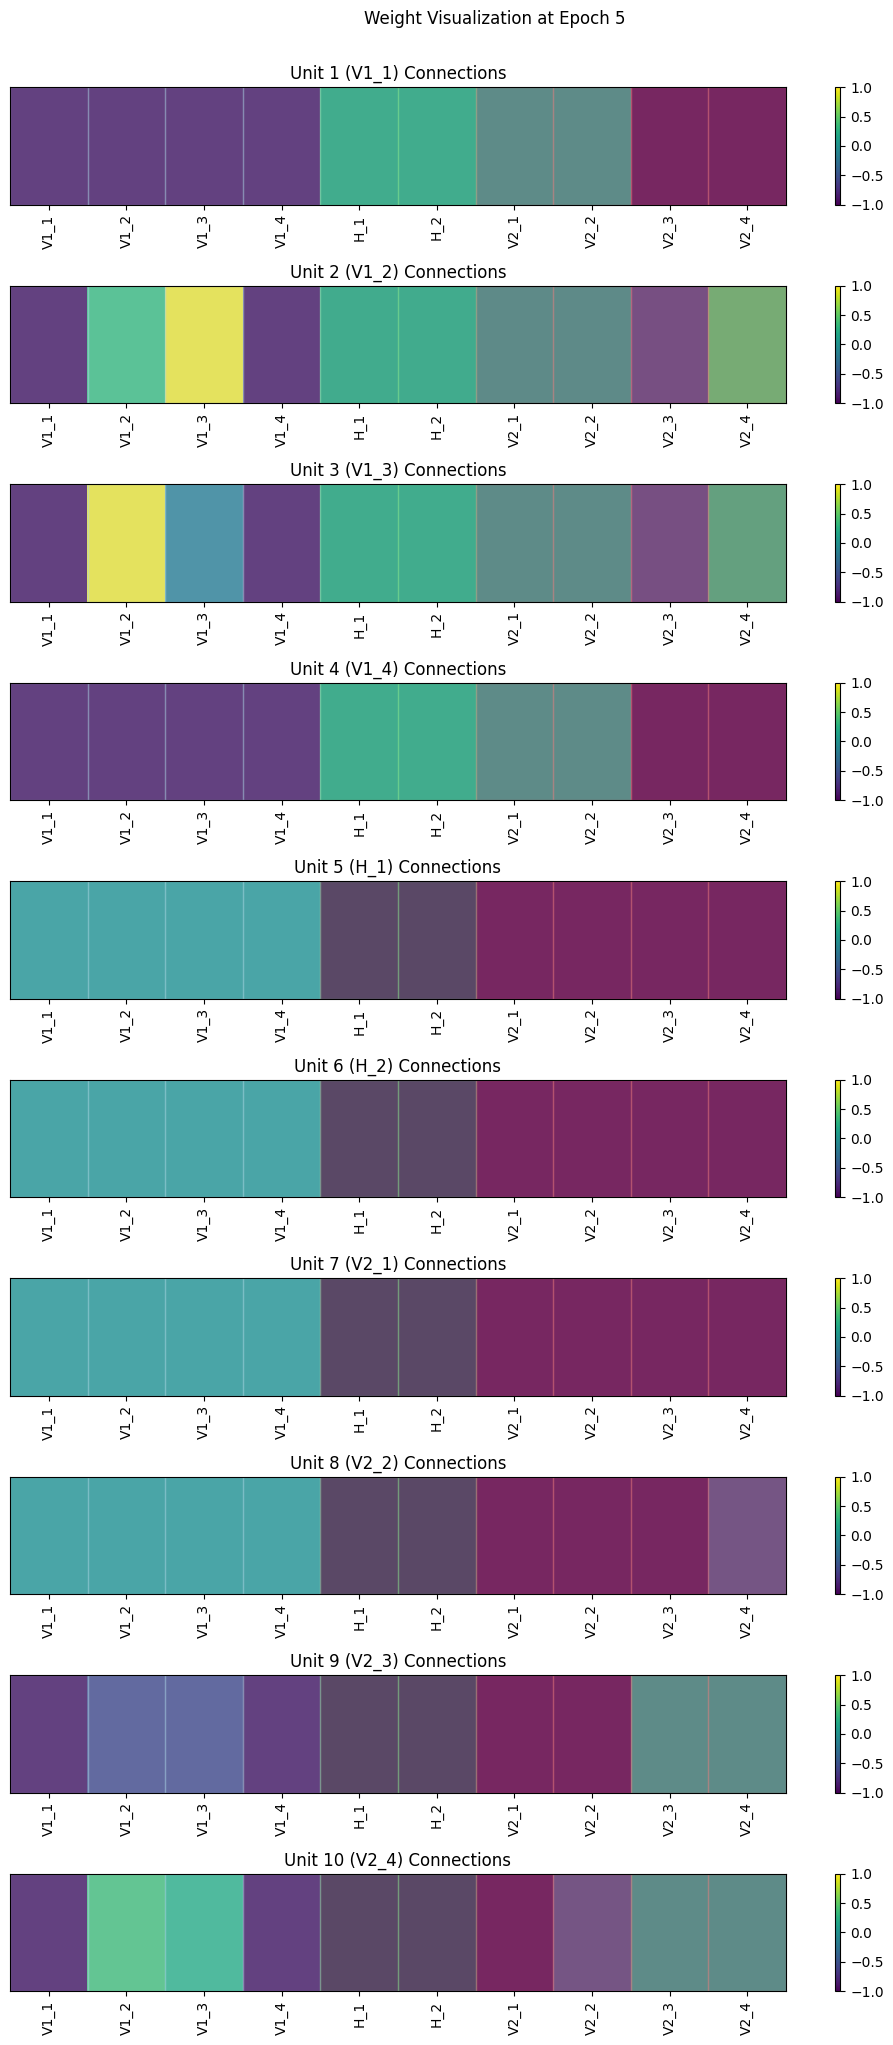

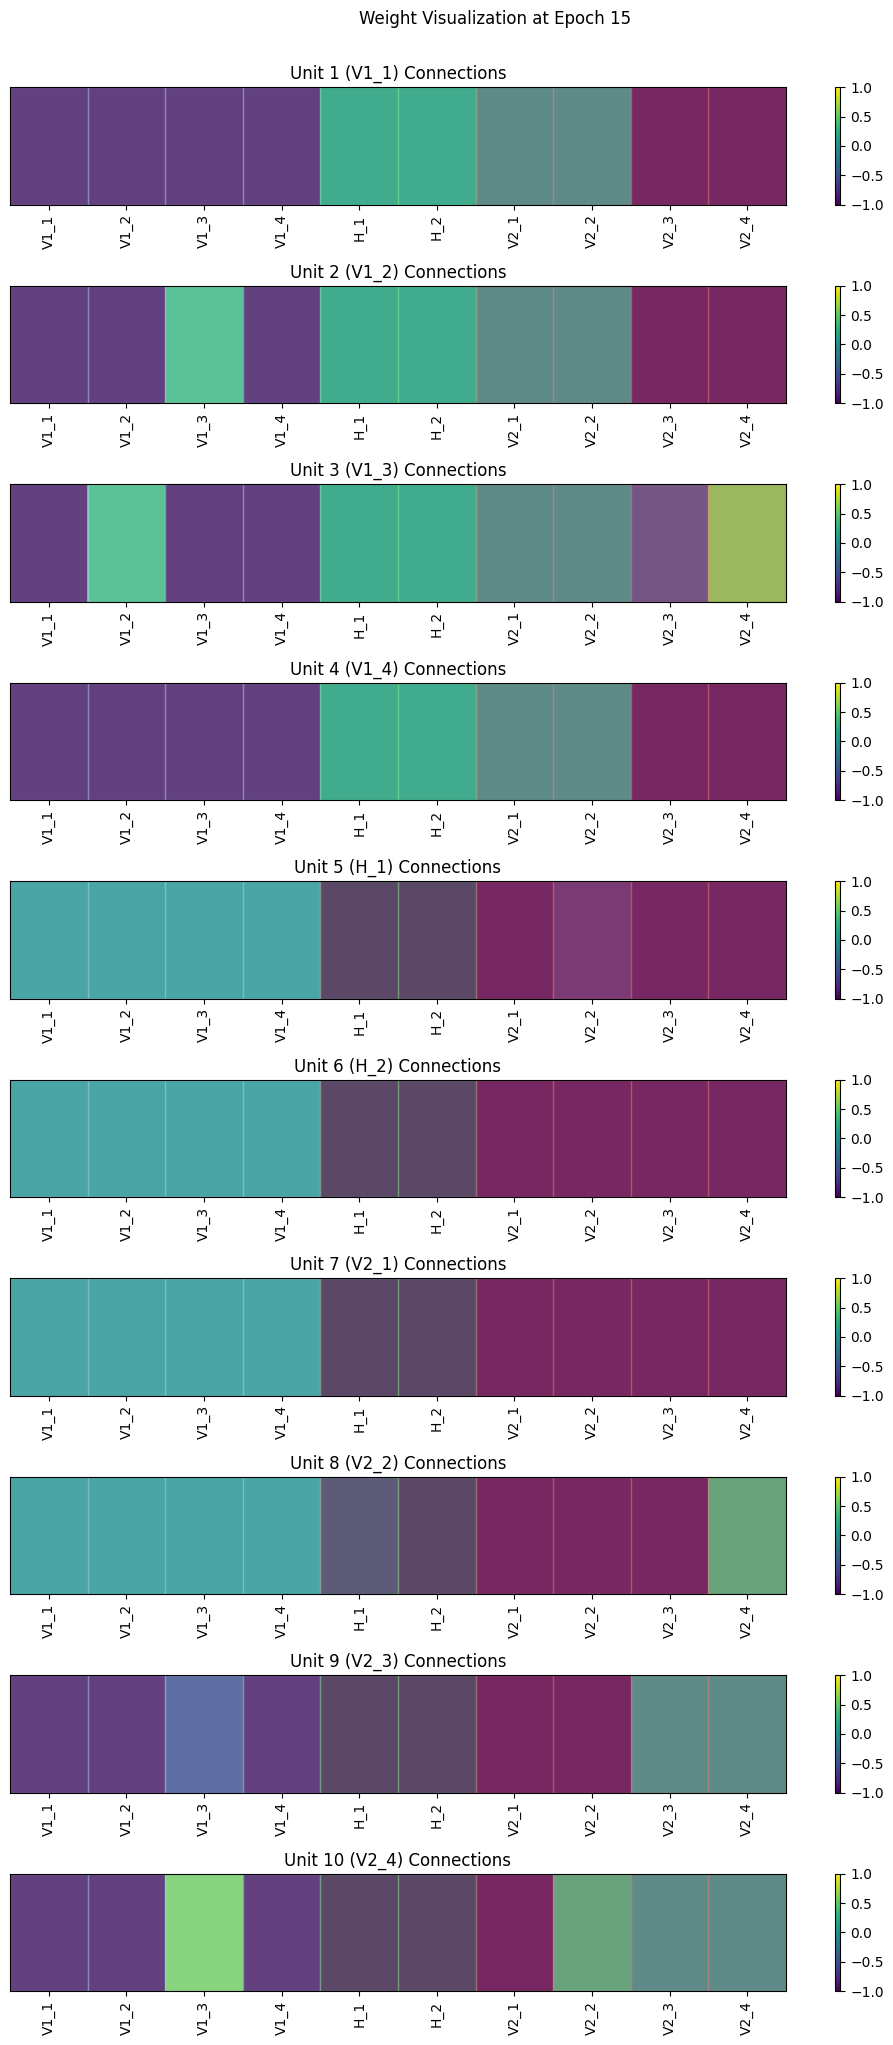

In [ ]:
# Define the visible units (V1 and V2)
v = torch.tensor([[1, 0, 0, 0, 1, 0, 0, 0],
                  [0, 1, 0, 0, 0, 1, 0, 0],
                  [0, 0, 1, 0, 0, 0, 1, 0],
                  [0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.float32)

# Create a Boltzmann Machine
b1 = example_package.BoltzmannMachine(8, 2, mode='binary')

# Train the network and plot weights at specific epochs
b1.TrainBatch(v, epochs=20, learningRate=2, plot_intervals=[5, 15])